# LightGBM  for Crop Type and Land Classification
> Using LightGBM Classifier for crop type mapping for SERVIR Sat ML training. 

- toc: true
- badges: true
- author: Zhuang-Fang Yi
- comments: false
- hide: true

This notebook teaches you to read satellite imagery (Sentinal-2) from **AWS public S3 Buckets** through AWS Public Data Program for crop type mapping. 

In [0]:
#install python packages to run this notebook 
!pip install -q rasterio rasterstats geopandas treeinterpreter lightgbm

In [0]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb

import rasterio
import rasterstats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from os import path as op
import pickle

In [1]:
# Mount drive to google colab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# root_dir = "/content/drive/My Drive"

# Random Forest Model for Crop Type and Land Classification

Using data created by SERVIR East Africa, RCMRD, and FEWSNET, we demonstrate how to train a LightGBM classifier over Trans Nzoia county, Kenya.

In [4]:
# read in training data
training_vectors = gpd.read_file(op.join(root_dir, 'training_data.geojson'))
training_vectors.head()

,name,description,geometry
0,Shadow,None,"MULTIPOLYGON (((34.83383 1.18204, 34.83577 1.1..."
1,Forestland,None,"MULTIPOLYGON (((35.30961 1.01328, 35.30964 1.0..."
2,Maize,early reproductive,"MULTIPOLYGON (((34.90904 1.09515, 34.90907 1.0..."
3,Sugarcane,no change..maize farm on the right and far lef...,"MULTIPOLYGON (((34.90750 1.08934, 34.90753 1.0..."
4,Maize,reproductive good crop,"MULTIPOLYGON (((34.87144 0.82953, 34.87147 0.8..."


In [5]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.name)
# classes = np.array(sorted(training_vectors.name.unique()))
classes

array(['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize',
       'Shadow', 'Sugarcane', 'Sunflower', 'Waterbody'], dtype=object)

In [6]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict                  

{'Built': 0,
 'Cloud': 1,
 'Fallow': 2,
 'Forestland': 3,
 'Grassland': 4,
 'Maize': 5,
 'Shadow': 6,
 'Sugarcane': 7,
 'Sunflower': 8,
 'Waterbody': 9}

In [9]:
%%time
# this larger cell reads data from a raster file for each training vector
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
# raster information
raster_file = op.join(root_dir, 'Trans_nzoia_2019_05-02.tif')
bands = 6

# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.name, training_vectors.geometry):
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the (non-buffered) geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        # for each label pixel (places where the mask is true)...
        label_pixels = np.argwhere(mask)
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])

CPU times: user 13.2 s, sys: 457 ms, total: 13.6 s
Wall time: 20.4 s


In [10]:
# convert the training data lists into the appropriate shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((160461, 6), (160461,))

In [11]:
# (optional) add extra band indices

# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(160461, 8)

In [0]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.00046882325363338024,
 1: 0.001597444089456869,
 2: 0.0004928536224741252,
 3: 1.970093973482535e-05,
 4: 0.000819000819000819,
 5: 1.5704257424187697e-05,
 6: 0.0002473410833539451,
 7: 0.0002824858757062147,
 8: 0.05263157894736842,
 9: 0.003115264797507788}

In [14]:
%%time
# initialize a lightgbm

lgbm = lgb.LGBMClassifier(
       objective='multiclass',
       class_weight = class_weight_dict,
       num_class = len(class_dict),
       metric = 'multi_logloss')

CPU times: user 79 µs, sys: 5 µs, total: 84 µs
Wall time: 90.4 µs


In [15]:
# fit the model to the data (training)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.00046882325363338024, 1: 0.001597444089456869,
                             2: 0.0004928536224741252, 3: 1.970093973482535e-05,
                             4: 0.000819000819000819, 5: 1.5704257424187697e-05,
                             6: 0.0002473410833539451, 7: 0.0002824858757062147,
                             8: 0.05263157894736842, 9: 0.003115264797507788},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_class=10, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
# predict on X_test to evaluate the model
preds = lgbm.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

In [0]:
model_name = 'light_gbm.sav'
pickle.dump(lgbm, open(op.join(root_dir, model_name), 'wb'))


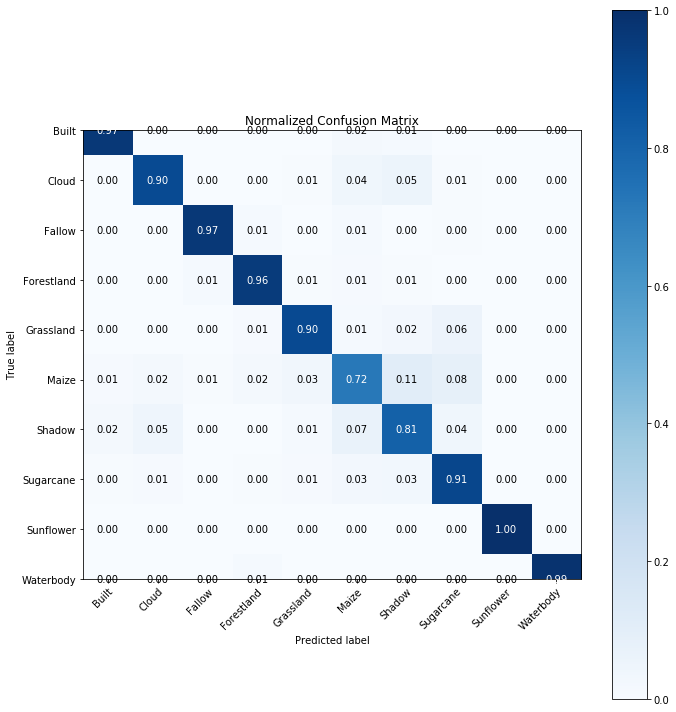

In [18]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

## Generate predictions over the full image

In [0]:
# if want to use the pretrained model for new imagery

# helper function for calculating ND*I indices (bands in the final dimension)
# match the pretrained model weight with the saved model above
model_name = 'light_gbm.sav'

def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)
  
lgbm = pickle.load(open(op.join(root_dir, model_name), 'rb'))

In [20]:
lgbm

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.00046882325363338024, 1: 0.001597444089456869,
                             2: 0.0004928536224741252, 3: 1.970093973482535e-05,
                             4: 0.000819000819000819, 5: 1.5704257424187697e-05,
                             6: 0.0002473410833539451, 7: 0.0002824858757062147,
                             8: 0.05263157894736842, 9: 0.003115264797507788},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_class=10, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
# src.close()
# dst.close()

In [0]:
# if want to use the pretrained model for new imagery
# The pretrained model is called "random_forest.sav"
# helper function for calculating ND*I indices (bands in the final dimension)

# open connections to our input and output images

# new_image = op.join(root_dir, 'Trans_nzoia_2019_10-04.tif')
new_image = raster_file
output_image = op.join(root_dir, "lgbm_classification.tif")
src = rasterio.open(new_image, 'r')
profile = src.profile
profile.update(
    dtype=rasterio.uint8,
    count=1,
)
dst = rasterio.open(output_image, 'w', **profile)

# perform prediction on each small image patch to minimize required memory
patch_size = 500

for i in range((src.shape[0] // patch_size) + 1):
    for j in range((src.shape[1] // patch_size) + 1):
        # define the pixels to read (and write)
        window = rasterio.windows.Window(
            j * patch_size,
            i * patch_size,
            # don't read past the image bounds
            min(patch_size, src.shape[1] - j * patch_size),
            min(patch_size, src.shape[0] - i * patch_size)
        )
        
        data = src.read(window=window)
        # read the image into the proper format, adding indices if necessary
        img_swp = np.moveaxis(data, 0, 2)
        img_flat = img_swp.reshape(-1, img_swp.shape[-1])

        img_ndvi = band_index(img_flat, 3, 2)
        img_ndwi = band_index(img_flat, 1, 3)

        img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

        # remove no data values, store the indices for later use
        # a later cell makes the assumption that all bands have identical no-data value arrangements
        m = np.ma.masked_invalid(img_w_ind)
        to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])
        
        # predict
        if not len(to_predict):
            continue
        img_preds = lgbm.predict(to_predict)
        
        # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
        # resize to the original image dimensions
        output = np.zeros(img_flat.shape[0])
        output[~m.mask[:,0]] = img_preds.flatten()
        output = output.reshape(*img_swp.shape[:-1])
        
        # create our final mask
        mask = (~m.mask[:,0]).reshape(*img_swp.shape[:-1])

        # write to the final file
        dst.write(output.astype(rasterio.uint8), 1, window=window)
        dst.write_mask(mask, window=window)
        # write to the final file
        dst.write(output.astype(rasterio.uint8), 1, window=window)
        dst.write_mask(mask, window=window)

src.close()
dst.close()